In [1]:
import pandas as pd

In [95]:
data_pickles = ['./data2015.pkl', './data2016.pkl','./data2017.pkl', './data2018.pkl','./data2019.pkl', './data2020.pkl']
dfs = [pd.read_pickle(f) for f in data_pickles]
df = pd.concat(dfs)
df

,quoteID,quotation,speaker,date,numOccurrences
5265,2015-08-19-056730,It's very important to understand how the ocea...,Helen McGregor,2015-08-19 11:46:00,2
5891,2015-09-28-067347,man-made emissions are an insignificant part o...,John Abraham,2015-09-28 23:16:52,1
7868,2015-09-29-052783,In the final months before crucial climate tal...,Bill de Blasio,2015-09-29 16:10:01,1
9207,2015-10-29-104475,The Baker Polito Administration is fully devot...,Peter Lorenz,2015-10-29 10:49:41,3
9709,2015-05-07-042445,The general narrative is addressing climate ch...,Dallas Burtraw,2015-05-07 17:55:43,2
...,...,...,...,...,...
5240963,2020-02-06-089077,The expected increase in severe weather due to...,Deb Gardner,2020-02-06 22:38:10,1
5241586,2020-02-05-114487,We will be an energetic champion of free trade...,Dominic Raab,2020-02-05 16:30:31,2
5243208,2020-02-10-057505,"Obama got health care, Trump got his tax cut, ...",Tom Steyer,2020-02-10 11:00:08,1
5243271,2020-02-19-061285,Our colleagues will also continue to work toge...,Markus Dohle,2020-02-19 08:37:21,1


In [3]:
docs = df['quotation'].to_numpy()

In [4]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [5]:
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

docs = [[token for token in doc if not token in stopwords ] for doc in docs]

In [6]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [7]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/home/arthur/Anaconda3/envs/ada/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [8]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=1)

In [9]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [10]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8843
Number of documents: 135492


In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    for num_topics in range(start, limit, step):
        print("Current pass {}".format(num_topics))
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
        )        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
import gensim
from gensim.models import CoherenceModel
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)

Current pass 2
Current pass 8
Current pass 14
Current pass 20
Current pass 26
Current pass 32
Current pass 38


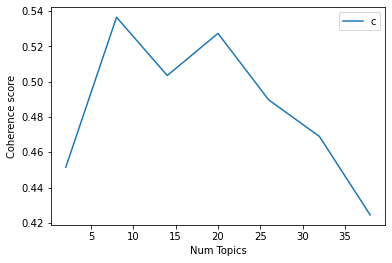

In [34]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [35]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 8
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [36]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
top_topics

Average topic coherence: -3.3051.


[([(0.14340065, 'climate'),
   (0.1206882, 'change'),
   (0.01605416, 'crisis'),
   (0.015979933, 'need'),
   (0.01195636, 'u'),
   (0.011782253, 'action'),
   (0.010987138, 'issue'),
   (0.009947581, 'time'),
   (0.009785962, 'one'),
   (0.00960955, 'government'),
   (0.009320388, 'way'),
   (0.009277243, 'make'),
   (0.009094358, 'world'),
   (0.008285309, 'future'),
   (0.007714253, 'take'),
   (0.006514412, 'must'),
   (0.0060205082, 'address'),
   (0.005781738, 'important'),
   (0.0057021743, 'country'),
   (0.0056956112, 'health')],
  -2.7108002762195076),
 ([(0.021724695, 'new'),
   (0.016197588, 'also'),
   (0.015376636, 'community'),
   (0.014537402, 'help'),
   (0.014300994, 'work'),
   (0.011073712, 'economy'),
   (0.009842448, 'solution'),
   (0.009590374, 'challenge'),
   (0.009466107, 'support'),
   (0.008801345, 'business'),
   (0.008318076, 'city'),
   (0.008074428, 'economic'),
   (0.0079620425, 'opportunity'),
   (0.0076747504, 'green'),
   (0.0075528496, 'across'),
 

In [37]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [38]:
viz_data = gensimvis.prepare(model, corpus, dictionary)

/home/arthur/Anaconda3/envs/ada/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [39]:
pyLDAvis.display(viz_data)

/home/arthur/Anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/arthur/Anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/arthur/Anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/arthur/Anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [89]:
classes = []
for i in range(len(df)):
    classes.append(max(model.get_document_topics(corpus[i]), key=lambda t: t[1])[0])

df['class'] = classes


IndexError: list index out of range

In [143]:
speakers_per_class = pd.DataFrame(df.groupby('class')['speaker'].value_counts())
speakers_per_class = speakers_per_class.rename({'speaker':'count'}, axis='columns')

In [144]:
speakers_per_class.reset_index()

,class,speaker,count
0,0,Bernie Sanders,69
1,0,President Barack Obama,42
2,0,Donald Trump,36
3,0,President Obama,31
4,0,Hillary Clinton,26
...,...,...,...
38369,7,Zachary Labe,1
38370,7,Zaheer Ahmed,1
38371,7,Zahid Hamid,1
38372,7,Zhang Jingyong,1


In [148]:
speakers_per_class.groupby('class').head()

count
class speaker                        
0     Bernie Sanders               69
      President Barack Obama       42
      Donald Trump                 36
      President Obama              31
      Hillary Clinton              26
1     Scott Pruitt                 27
      Alexandria Ocasio-Cortez     11
      António Guterres             11
      Dustin Duncan                11
      Shane Rattenbury             11
2     Narendra Modi               122
      Catherine McKenna            63
      Justin Trudeau               49
      Claire Perry                 37
      Patricia Espinosa            36
3     Donald Trump                 52
      Ted Cruz                     23
      President Donald Trump       22
      Marc Morano                  21
      Scott Pruitt                 17
4     Michael Mann                 49
      Narendra Modi                37
      President Obama              36
      Petteri Taalas               35
      President Barack Obama       31
5     Bernie Sanders             1162
      President Barack Obama      797
      Jay Inslee                  676
      Justin Trudeau              635
      Jerry Brown                 628
6     Bernie Sanders               12
      Kathy Hochul                 11
      Hillary Clinton               7
      Andrew Cuomo                  6
      Jared Polis                   6
7     Scott Pruitt                 65
      Michael Mann                 46
      Petteri Taalas               44
      Pope Francis                 33
      Gavin Schmidt                27